# Training an agent with Regression Network

So we have generated our training dataset. Now we are going to use this notebook to traing a regular logistic regression model. We have used dataiku tool extensivelly so mosy of the code here are copied from dataiku generated notebook.

In [1]:
# Execute the following cell only ones. If you need to re-execute it. First restart the notebook. It is needed to access the data folder.
%cd ..

/Users/hakanonal/vscode/hang-man-ai


In [2]:
import pandas as pd

ml_dataset = pd.read_csv('data/states.csv',usecols=['action_to_play', 'guessed_letters','board'])#['action_to_play', 'length', 'guessed_letters', 'known_count', 'board', 'unknown_count']
ml_dataset.head(5)

,guessed_letters,board,action_to_play
0,NaN,"_,_",a
1,a,"a,_",z
2,"a,z","a,_",r
3,"a,z,r","a,_",l
4,"a,z,r,l","a,_",t


In [3]:
def coerce_to_unicode(x):
    if sys.version_info < (3, 0):
        if isinstance(x, str):
            return unicode(x,'utf-8')
        else:
            return unicode(x)
    else:
        return str(x)


categorical_features = ['guessed_letters', 'board']
numerical_features = []#['length', 'known_count', 'unknown_count']
text_features = []
for feature in categorical_features:
    ml_dataset[feature] = ml_dataset[feature].apply(coerce_to_unicode)
for feature in text_features:
    ml_dataset[feature] = ml_dataset[feature].apply(coerce_to_unicode)
for feature in numerical_features:
    ml_dataset[feature] = ml_dataset[feature].astype('double')

In [4]:
target_map = {'a': 0, 'l': 1, 'ı': 2, 'k': 3, 'm': 4, 'r': 5, 'n': 6, 'e': 7, 'i': 8, 'd': 9, 't': 10, 'ç': 11, 'c': 12, 'b': 13, 's': 14, 'ş': 15, 'y': 16, 'z': 17, 'f': 18, 'ğ': 19, 'o': 20, 'u': 21, 'v': 22, 'g': 23, 'p': 24, 'h': 25, 'ü': 26, 'ö': 27, 'j': 28}
ml_dataset['__target__'] = ml_dataset['action_to_play'].map(str).map(target_map)
del ml_dataset['action_to_play']


# Remove rows for which the target is unknown.
ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ml_dataset, test_size=0.2)

In [6]:
from collections import Counter

LIMIT_DUMMIES = 100

categorical_to_dummy_encode = ['guessed_letters', 'board']

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in categorical_to_dummy_encode:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(train, categorical_to_dummy_encode)

def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            dummy_name = u'%s_value_%s' % (feature, coerce_to_unicode(dummy_value))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print ('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(train)

dummy_encode_dataframe(test)

/var/folders/_x/ysf6r41n0d54yl5_ts3xbqqr0000gn/T/ipykernel_8869/591155984.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = (df[feature] == dummy_value).astype(float)


Dummy-encoded feature guessed_letters
Dummy-encoded feature board
Dummy-encoded feature guessed_letters
Dummy-encoded feature board


In [7]:
import numpy as np

train_X = train.drop('__target__', axis=1)
test_X = test.drop('__target__', axis=1)

train_Y = np.array(train['__target__'])
test_Y = np.array(test['__target__'])

In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l2",random_state=1337,max_iter=1000)

In [9]:
%time clf.fit(train_X, train_Y)

import pickle
pickle.dump(clf, open('data/lr_model.sav', 'wb'))

CPU times: user 14min 35s, sys: 2min 39s, total: 17min 15s
Wall time: 12min 4s


In [10]:
%time _predictions = clf.predict(test_X)
%time _probas = clf.predict_proba(test_X)
predictions = pd.Series(data=_predictions, index=test_X.index, name='predicted_value')
cols = [
    u'probability_of_value_%s' % label
    for (_, label) in sorted([(int(target_map[label]), label) for label in target_map])
]
probabilities = pd.DataFrame(data=_probas, index=test_X.index, columns=cols)

# Build scored dataset
results_test = test_X.join(predictions, how='left')
results_test = results_test.join(probabilities, how='left')
results_test = results_test.join(test['__target__'], how='left')
results_test = results_test.rename(columns= {'__target__': 'action_to_play'})

CPU times: user 227 ms, sys: 93.8 ms, total: 320 ms
Wall time: 214 ms
CPU times: user 257 ms, sys: 12.9 ms, total: 270 ms
Wall time: 140 ms


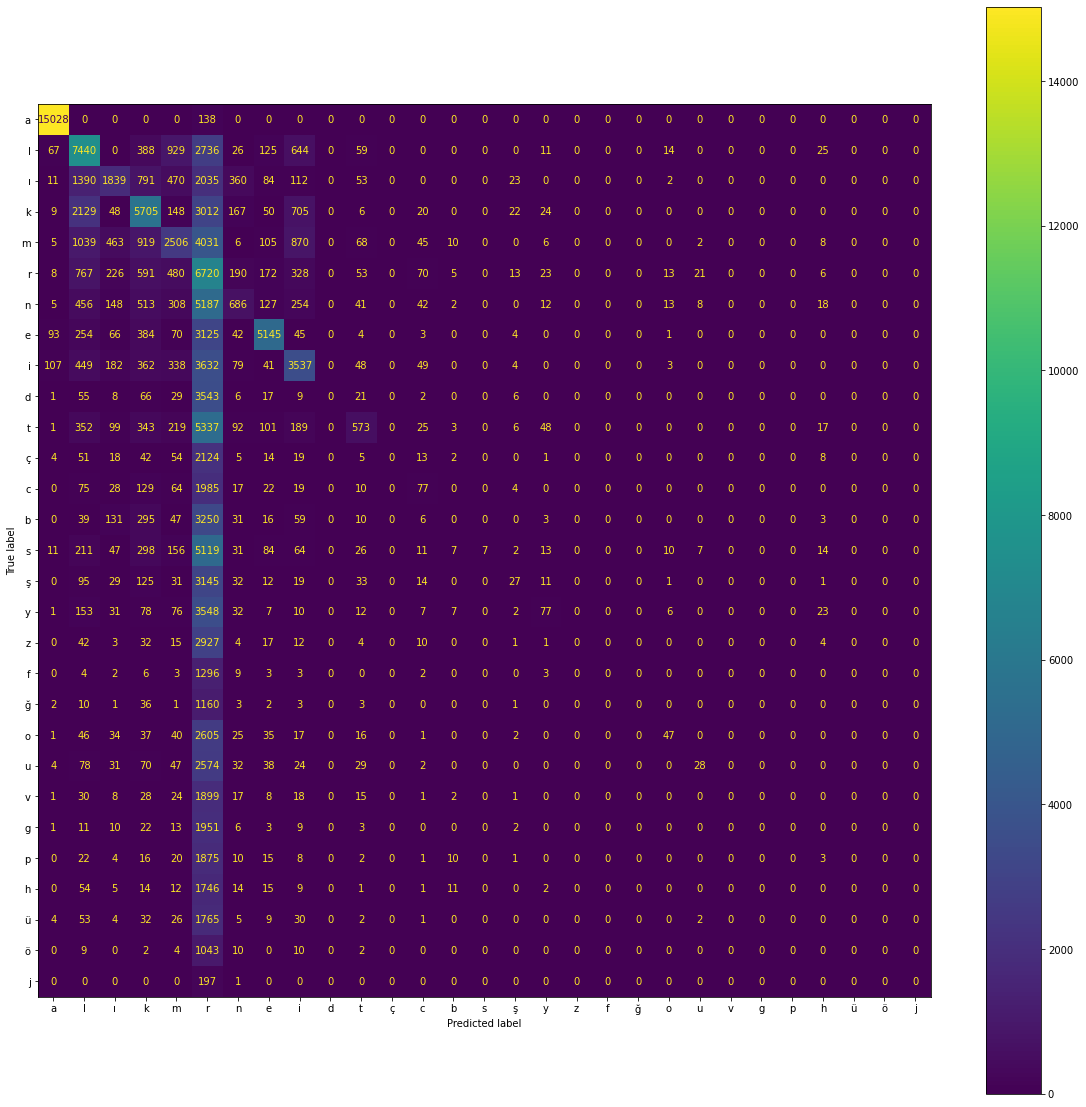

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 20,20
ConfusionMatrixDisplay.from_predictions(test_Y,_predictions,display_labels=np.array(list(target_map.keys())))
plt.show()